In [2]:
from chromatic import *
import emcee
import corner
import speclite as speclite
from speclite import filters
from tqdm import tqdm
from matplotlib import cm
from matplotlib.artist import Artist
from scipy.optimize import minimize
from scipy.optimize import curve_fit

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('tableau-colorblind10')

  0%|          | 0/3 [00:00<?, ?it/s]

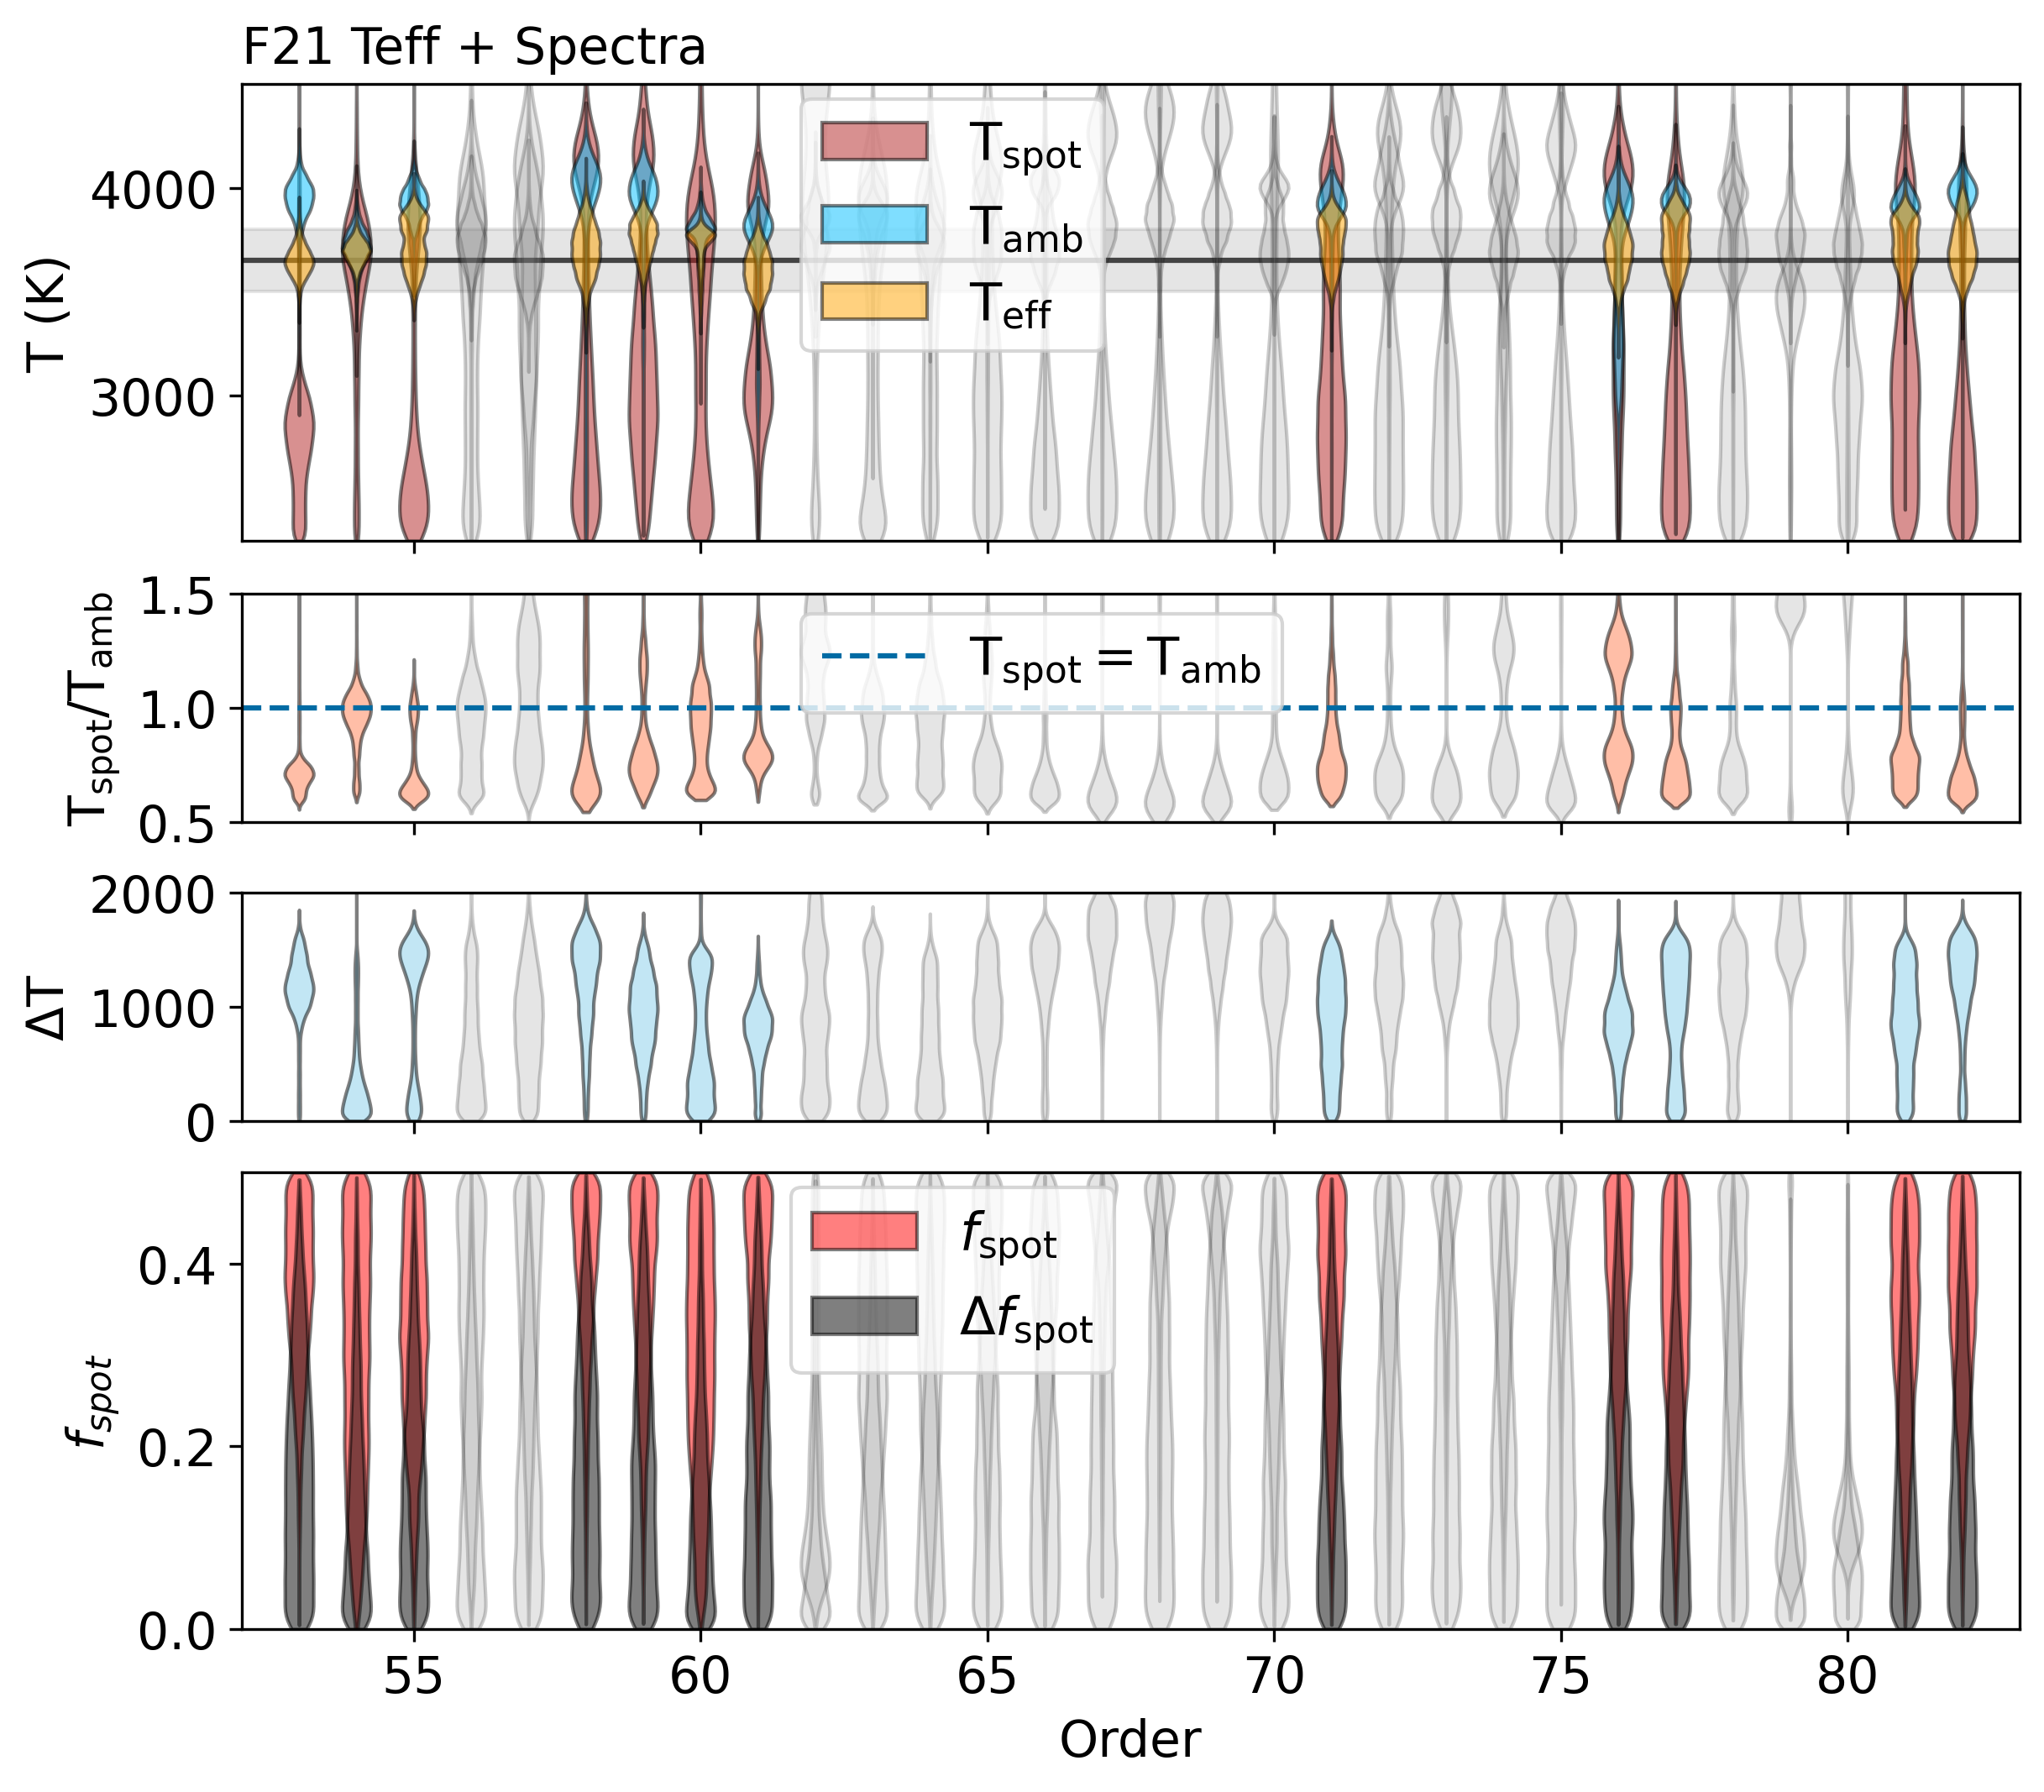

 33%|███▎      | 1/3 [00:13<00:27, 13.62s/it]

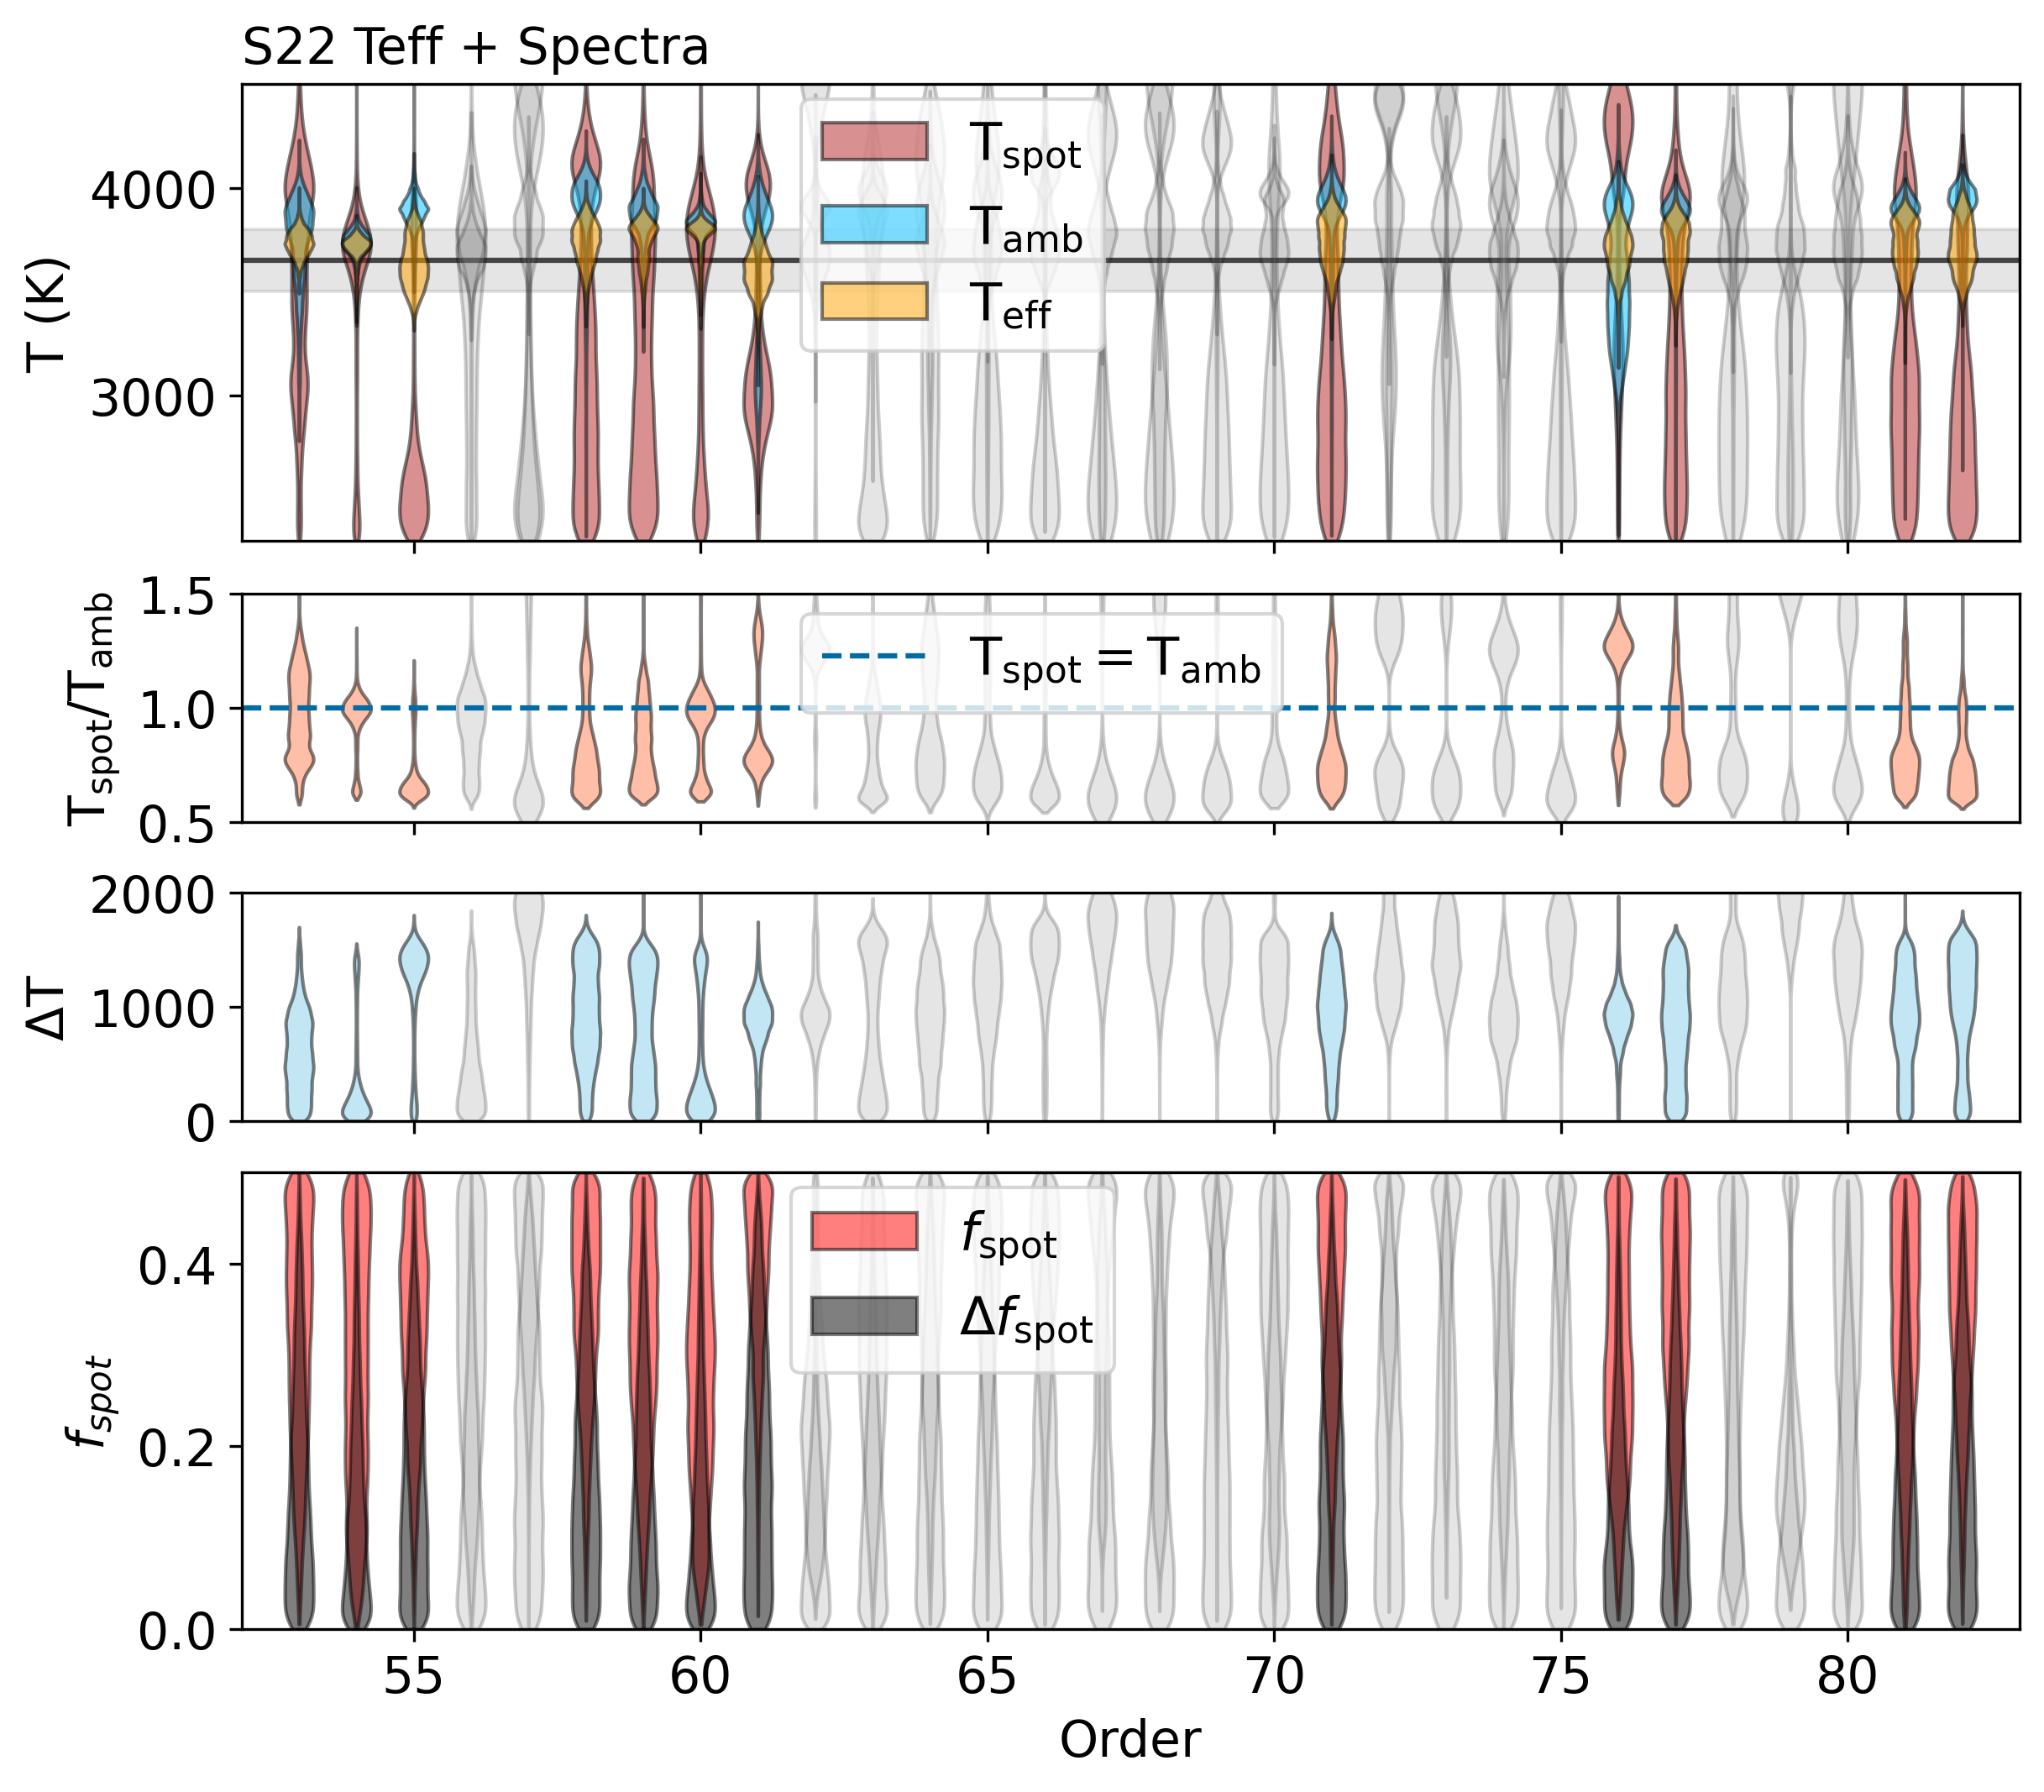

 67%|██████▋   | 2/3 [00:27<00:13, 13.59s/it]

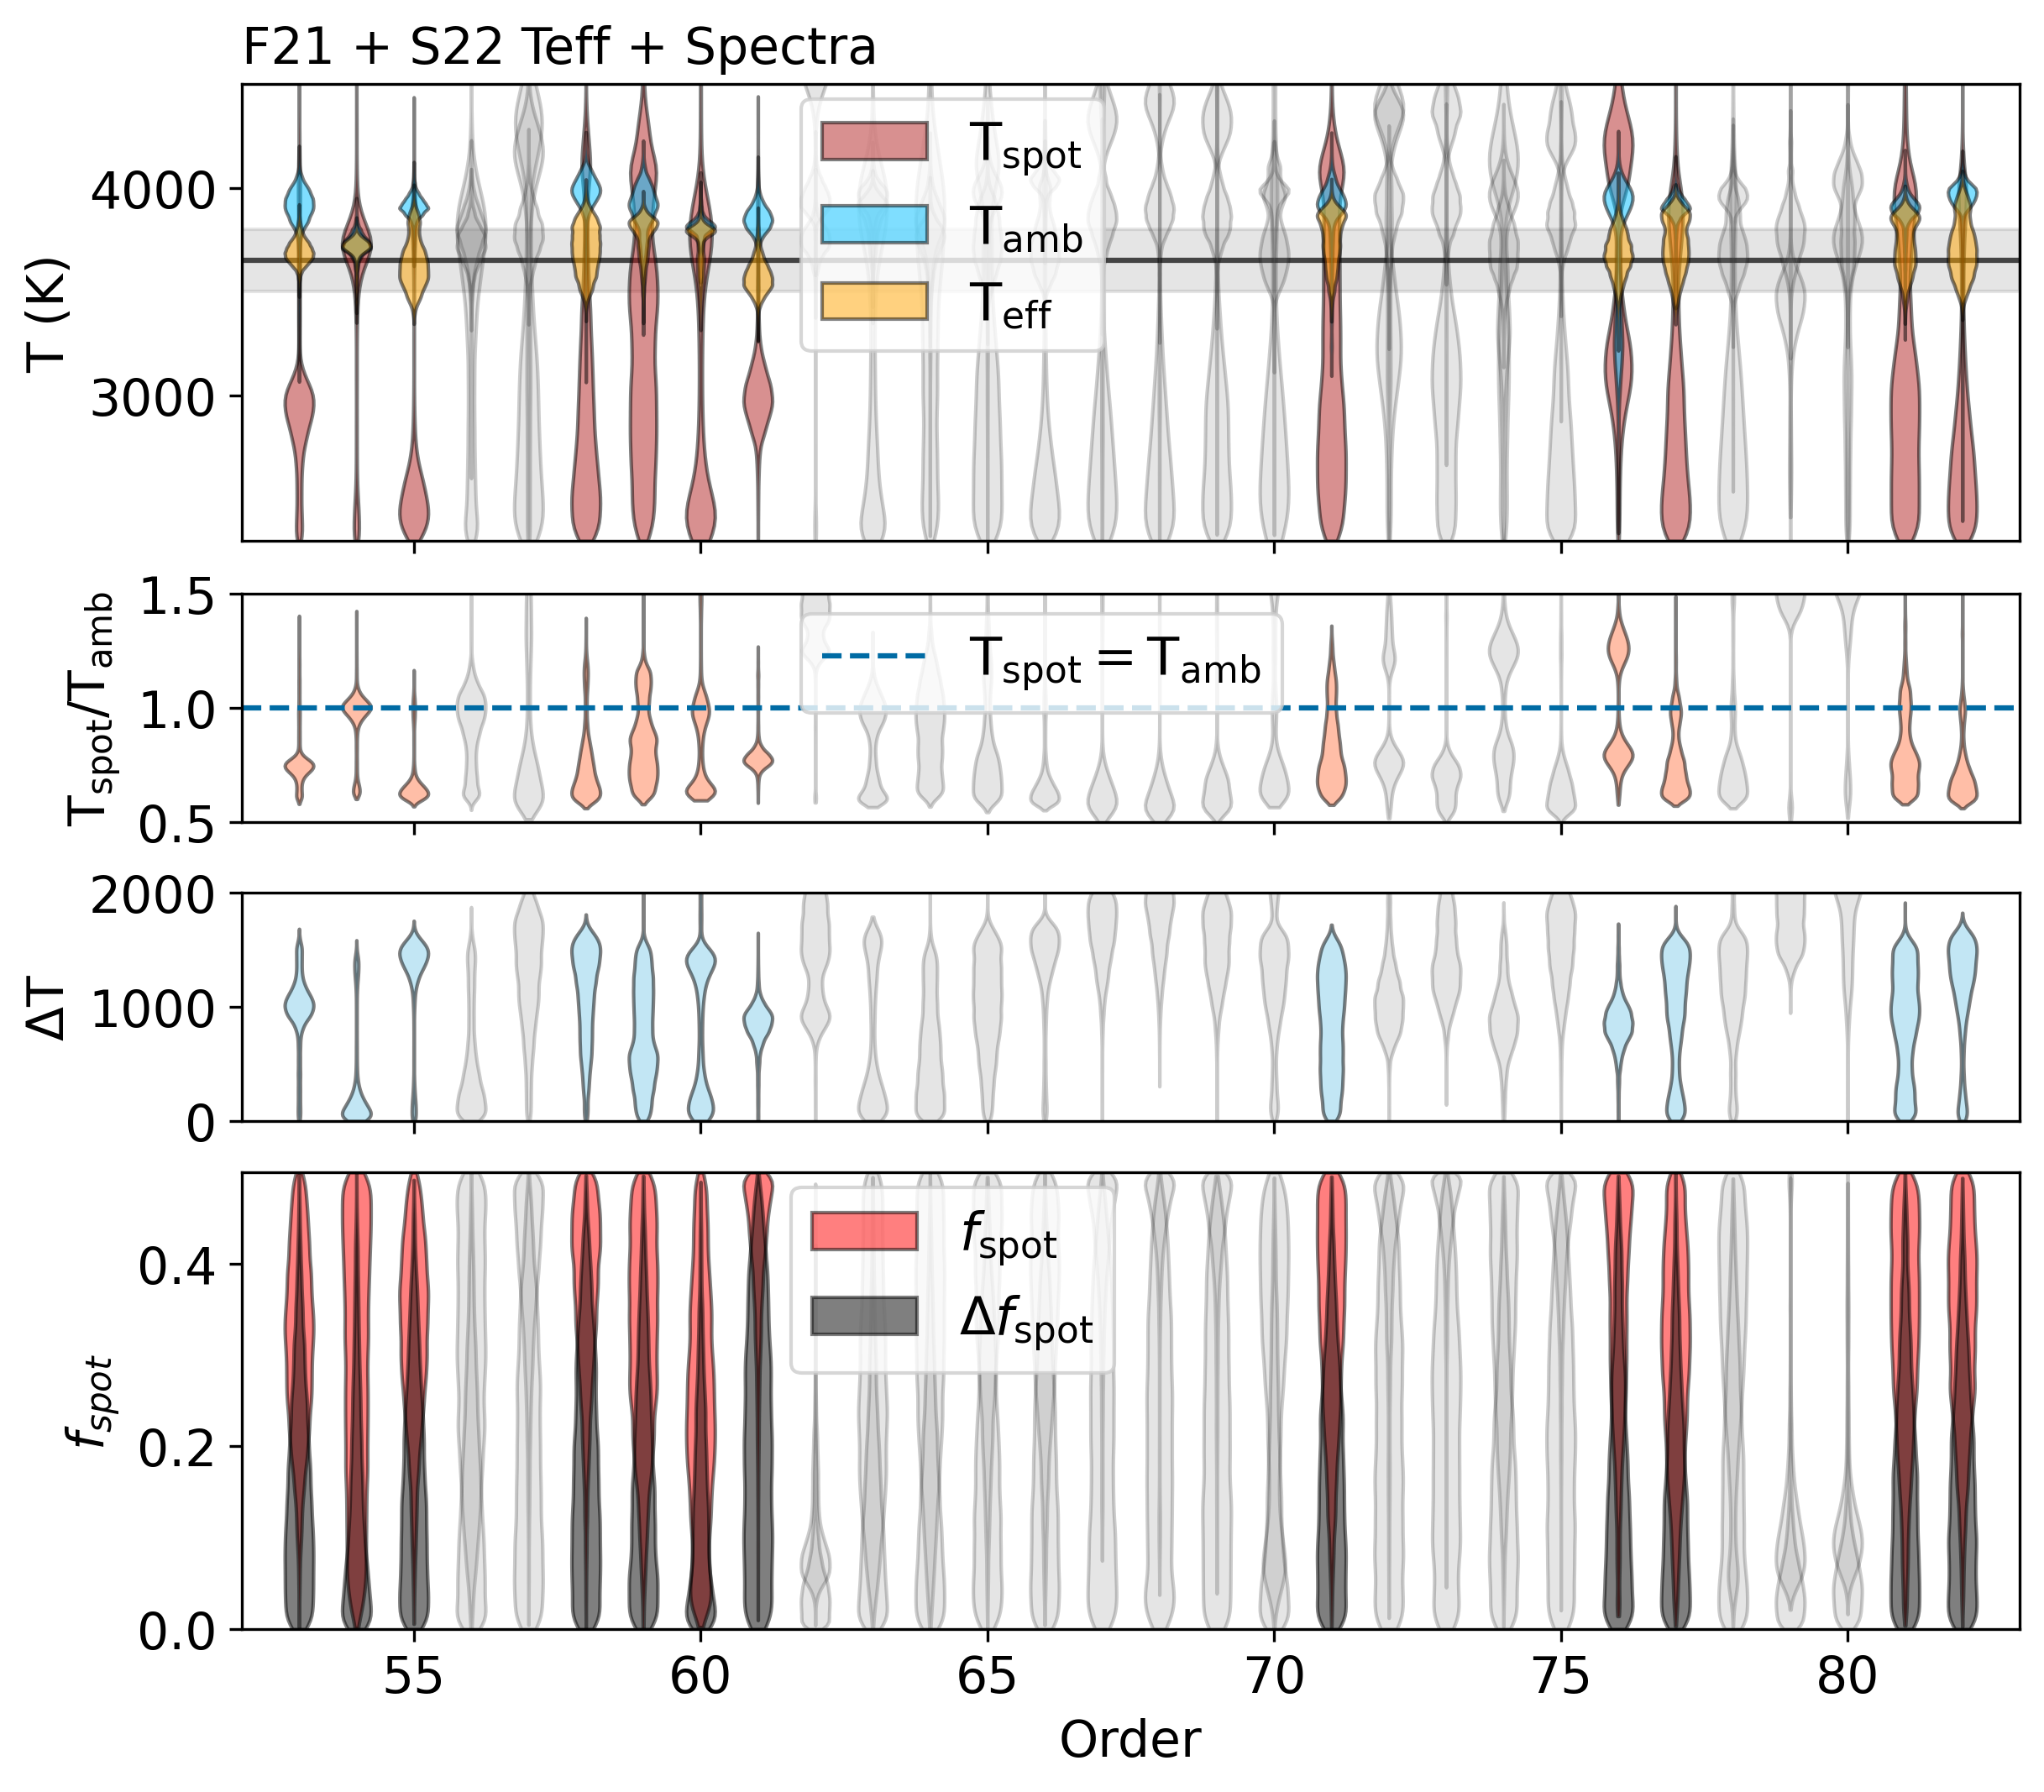

100%|██████████| 3/3 [00:40<00:00, 13.63s/it]


In [7]:
ordernumbers = np.arange(53,83)
bad_array = np.array([56,57,62,63,64,65,66,67,68,72,74,78,79,69,70,73,75,80,83])

nsteps = 1000
modeltype = 'individual_orders_Teff_Spec'
modelname = 'Teff + Spectra'
visitnames = ['F21','S22','F21 + S22']
visits = ['F21','S22','combined']

# nsteps = 2000
# modeltype = f'Final_Teff_Phot_Spec'
# modelname = ' Teff + Variability + Spectra'
# visitnames = ['F21','S22']
# visits = ['F21','S22']

# nsteps = 3000
# modeltype = f'Final_Teff_Phot_Spec'
# modelname = ' Teff + Variability + Spectra'
# visitnames = ['F21 + S22']
# visits = ['combined']

i = 0
for visit in tqdm(visits):
    
    fig, ax = plt.subplots(4,1,figsize=(8, 7),sharex=True,gridspec_kw=dict(height_ratios=[1,0.5,0.5,1.0]))
    ax[0].set_title(f'{visitnames[i]} {modelname}',loc='left')
    ax[0].set_ylim(2300,4500)
    ax[0].set_ylabel('T (K)',fontsize='x-large')
    ax[0].axhspan(3500,3800,color='gray',alpha=0.2,zorder=-100) 
    ax[0].axhline(3650,color='k',alpha=0.7,zorder=-99)

    ax[1].set_ylabel(r'$\rm{T_{spot}/T_{amb}}$')
    ax[1].set_ylim(0.5,1.5)
    ax[1].axhline(1,linestyle='--',label=r'$\rm{T_{spot}=T_{amb}}$')

    ax[2].set_ylabel(r'$\Delta$T')
    ax[2].set_ylim(0,2000)    

    ax[3].set_xlim(ordernumbers[0]-1,ordernumbers[-1]+1)
    ax[3].set_ylim(0,0.5)
    ax[3].set_xlabel('Order',fontsize='x-large')
    ax[3].set_ylabel('$f_{spot}$',fontsize='x-large')
    
    for ordernum in ordernumbers:
        l = ordernum - 53
        c11 = 'firebrick'
        c12 = 'deepskyblue'
        c13 = 'orange'
        c21 = 'coral'
        c31 = 'skyblue'
        c41 = 'red'
        c42 = 'black'
        alpha = 0.5
        bad_flag = (bad_array == ordernum)
        if np.any(bad_flag):
            c11 = 'gray'
            c12 = 'gray'
            c13 = 'gray'
            c21 = 'gray'
            c31 = 'gray'
            c41 = 'gray'
            c42 = 'gray'
            alpha = 0.2
        reader = emcee.backends.HDFBackend(f'../data/samples/{visit}_{ordernum}_{modeltype}_{nsteps}steps.h5')
        sampler = reader.get_chain(discard=int(0.25*nsteps), flat=True)
        samples = sampler.reshape((-1, 4)).T
        fspots = samples[0] 
        dfspots = samples[1]
        t_spot = samples[2]
        t_amb = samples[3]
        t_eff = (fspots*(t_spot**4) + (1-fspots)*(t_amb**4))**(1/4)
        t_ratio = t_spot/t_amb
        delta_t = np.abs(t_amb-t_spot)

        Tspots = ax[0].violinplot(t_spot, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in Tspots['bodies']:
            pc.set_facecolor(c11)
            if l == 0: 
                pc.set_label(r'$\rm{T_{spot}}$')
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
        Tambs = ax[0].violinplot(t_amb, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in Tambs['bodies']:
            if l == 0: 
                pc.set_label(r'$\rm{T_{amb}}$')
            pc.set_facecolor(c12)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
        Teffs = ax[0].violinplot(t_eff, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in Teffs['bodies']:
            if l == 0: 
                pc.set_label(r'$\rm{T_{eff}}$')
            pc.set_facecolor(c13)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)            
            
        ratios = ax[1].violinplot(t_ratio, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in ratios['bodies']:
            pc.set_facecolor(c21)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
            
        deltas = ax[2].violinplot(delta_t, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in deltas['bodies']:
            pc.set_facecolor(c31)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)

        fspots = ax[3].violinplot(fspots, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in fspots['bodies']:
            if l == 0: 
                pc.set_label(r'$f_{\rm{spot}}$')
            pc.set_facecolor(c41)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
            
        dfspots = ax[3].violinplot(dfspots, positions=[ordernum],showextrema=False, showmedians=False)
        for pc in dfspots['bodies']:
            if l == 0: 
                pc.set_label(r'$\Delta f_{\rm{spot}}$')
            pc.set_facecolor(c42)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)  
    i += 1

    ax[0].legend(loc='upper center',bbox_to_anchor=(0.4, 1.025),fontsize=15)
    ax[1].legend(loc='upper center',bbox_to_anchor=(0.45, 1.025),fontsize=15)
    ax[3].legend(loc='upper center',bbox_to_anchor=(0.4, 1.025),fontsize=15)
        
    plt.savefig(f'../figs/{visit}_{modeltype}_violin.png',dpi=200)
    plt.show()

## Photometry Violin Plots

In [ ]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)
 
nsteps = 1000
modeltype = f'Final_Teff_Phot'
visits = ['F21','S22']
visitlabels = ['F21','S22']
ordernumbers = [1,2]
        
fig, ax = plt.subplots(2,2,figsize=(4,4),sharex=True)
ax[0,0].set_ylim(2300,4500)
ax[0,0].set_ylabel('T (K)')
ax[0,0].axhspan(3400,3800,color='gray',alpha=0.2,zorder=-100) 
ax[0,0].axhline(3600,color='k',alpha=0.7,zorder=-99)

ax[1,0].set_ylabel(r'$\rm{T_{spot}/T_{amb}}$',fontsize='x-large')
ax[1,0].set_ylim(0.5,1.5)
ax[1,0].set_xticks(ordernumbers, visitlabels)

ax[1,1].set_ylabel(r'$\Delta$T',fontsize='x-large')
ax[1,1].set_ylim(0,2000)    
ax[1,1].set_xticks(ordernumbers, visitlabels)

ax[0,1].set_xlim(ordernumbers[0]-1,ordernumbers[-1]+1)
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_ylabel('$f_{spot}$',fontsize='x-large')

j = 0
for visit in visits:
    for ordernum in ordernumbers:
        l = ordernum - 1
        c11 = 'firebrick'
        c12 = 'deepskyblue'
        c13 = 'orange'
        c21 = 'coral'
        c31 = 'skyblue'
        c41 = 'red'
        c42 = 'black'
        alpha = 0.5

        reader = emcee.backends.HDFBackend(f'../data/samples/{visit}_52_{modeltype}_{nsteps}steps.h5')
        sampler = reader.get_chain(discard=int(0.25*nsteps), flat=True)
        samples = sampler.reshape((-1, 4)).T
        fspots = samples[0] 
        dfspots = samples[1]
        t_spot = samples[2]
        t_amb = samples[3]
        t_eff = (fspots*(t_spot**4) + (1-fspots)*(t_amb**4))**(1/4)
        t_ratio = t_spot/t_amb
        delta_t = np.abs(t_amb-t_spot)

        Tspots = ax[0,0].violinplot(t_spot, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        Tambs = ax[0,0].violinplot(t_amb, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        Teffs = ax[0,0].violinplot(t_eff, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        for pc in Tambs['bodies']:
            if l == 0: 
                pc.set_label(r'$\rm{T_{amb}}$')
            pc.set_facecolor(c12)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
        for pc in Teffs['bodies']:
            if l == 0: 
                pc.set_label(r'$\rm{T_{eff}}$')
            pc.set_facecolor(c13)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
        for pc in Tspots['bodies']:
            pc.set_facecolor(c11)
            if l == 0: 
                pc.set_label(r'$\rm{T_{spot}}$')
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)

        ratios = ax[1,0].violinplot(t_ratio, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        for pc in ratios['bodies']:
            pc.set_facecolor(c21)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)

        deltas = ax[1,1].violinplot(delta_t, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        for pc in deltas['bodies']:
            pc.set_facecolor(c31)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)

        fspots = ax[0,1].violinplot(fspots, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        for pc in fspots['bodies']:
            if l == 0: 
                pc.set_label(r'$f_{\rm{spot}}$')
            pc.set_facecolor(c41)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
        dfspots = ax[0,1].violinplot(dfspots, positions=[ordernumbers[j]],showextrema=False, showmedians=False)
        for pc in dfspots['bodies']:
            if l == 0: 
                pc.set_label(r'$\Delta f_{\rm{spot}}$')
            pc.set_facecolor(c42)
            pc.set_edgecolor('black')
            pc.set_alpha(alpha)
            
    j += 1

# ax[0,0].legend(loc='lower left',fontsize=10)
# ax[0,1].legend(loc='upper right',fontsize=10)
    
plt.savefig(f'../figs/Final_Teff_Phot_violin.png',dpi=100)
plt.show()